<a href="https://colab.research.google.com/github/Russo-Federico/ML-Projects/blob/main/ComputerVision/CNN-image-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garbage image classification

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sn
import tensorflow as tf
import cv2

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from google.colab import userdata

In [65]:
# retrieving kaggle secrets
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

# endure reproducibility by usinga a custom seed
my_seed = 111
np.random.seed(my_seed)
tf.random.set_seed(my_seed)

# fixed values
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

 ## Loading data

In [28]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zlatan599/garbage-dataset-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/garbage-dataset-classification


In [29]:
# Print all folders/files under the dataset path
for root, dirs, files in os.walk(path):
    print("Root:", root)
    print("Dirs:", dirs)
    print("Files:", files[:5])  # print only first 5 files per folder
    print("-"*50)

Root: /kaggle/input/garbage-dataset-classification
Dirs: ['Garbage_Dataset_Classification']
Files: []
--------------------------------------------------
Root: /kaggle/input/garbage-dataset-classification/Garbage_Dataset_Classification
Dirs: ['images']
Files: ['metadata.csv']
--------------------------------------------------
Root: /kaggle/input/garbage-dataset-classification/Garbage_Dataset_Classification/images
Dirs: ['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']
Files: []
--------------------------------------------------
Root: /kaggle/input/garbage-dataset-classification/Garbage_Dataset_Classification/images/metal
Dirs: []
Files: ['metal_01381.jpg', 'metal_00775.jpg', 'metal_02570.jpg', 'metal_02569.jpg', 'metal_01272.jpg']
--------------------------------------------------
Root: /kaggle/input/garbage-dataset-classification/Garbage_Dataset_Classification/images/glass
Dirs: []
Files: ['glass_01302.jpg', 'glass_01067.jpg', 'glass_00062.jpg', 'glass_00675.jpg', 'glass_044

In [66]:
dataset_path = os.path.join(path, "Garbage_Dataset_Classification/images")

# training dataset (80%)
train_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=VALIDATION_SPLIT,    # 20% will be used for testing
    subset="training",
    seed=my_seed,                # for reproducibility
    image_size=IMAGE_SIZE,   # resize images
    batch_size=BATCH_SIZE,
    label_mode='categorical', # one-hot labels
    shuffle=True            # optional, default is True
)

# testing dataset (20%)
test_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=my_seed,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False  # usually validation/test is not shuffled
)

Found 13901 files belonging to 6 classes.
Using 11121 files for training.
Found 13901 files belonging to 6 classes.
Using 2780 files for validation.


In [40]:
# image labes
print(train_dataset.class_names)
num_classes = len(train_dataset.class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Data augmentation

In [32]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

## Performance enhancements

In [33]:
# automatically chooses the optimal number of batches to prefetch
AUTOTUNE = tf.data.AUTOTUNE

# prepare the next batch of data in the background while the current batch is being processed
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Build a CNN model

In [41]:
model = models.Sequential([
    layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),  # RGB images
    data_augmentation,
    layers.Rescaling(1./255),                        # normalize pixels
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### Compile the model

In [42]:
model.compile(
    optimizer='adam', # how to update the weights
    loss='categorical_crossentropy', # standard loss function for multi-class classification
    metrics=['accuracy'] # accuracy # correct predictions/total predictions
)

In [43]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,414 (12.61 MB)

 Trainable params: 3,305,414 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## Fit the model

In [44]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=15
)

Epoch 1/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - accuracy: 0.2920 - loss: 1.7180 - val_accuracy: 0.5277 - val_loss: 1.2356
Epoch 2/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 483s 1s/step - accuracy: 0.4662 - loss: 1.4057 - val_accuracy: 0.5586 - val_loss: 1.1473
Epoch 3/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 424s 1s/step - accuracy: 0.5090 - loss: 1.3041 - val_accuracy: 0.5871 - val_loss: 1.0525
Epoch 4/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 463s 1s/step - accuracy: 0.5479 - loss: 1.2176 - val_accuracy: 0.5694 - val_loss: 1.0688
Epoch 5/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 480s 1s/step - accuracy: 0.5787 - loss: 1.1649 - val_accuracy: 0.5583 - val_loss: 1.1391
Epoch 6/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - accuracy: 0.5880 - loss: 1.1061 - val_accuracy: 0.5759 - val_loss: 1.0309
Epoch 7/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 429s 1s/step - accuracy: 0.6024 - loss: 1.0861 - val_accuracy: 0.5777 - val_loss: 1.0404
Epoch 8/15
348/348 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.6244 - loss: 1.0460 - val_accu

## Accuracy and loss graphs

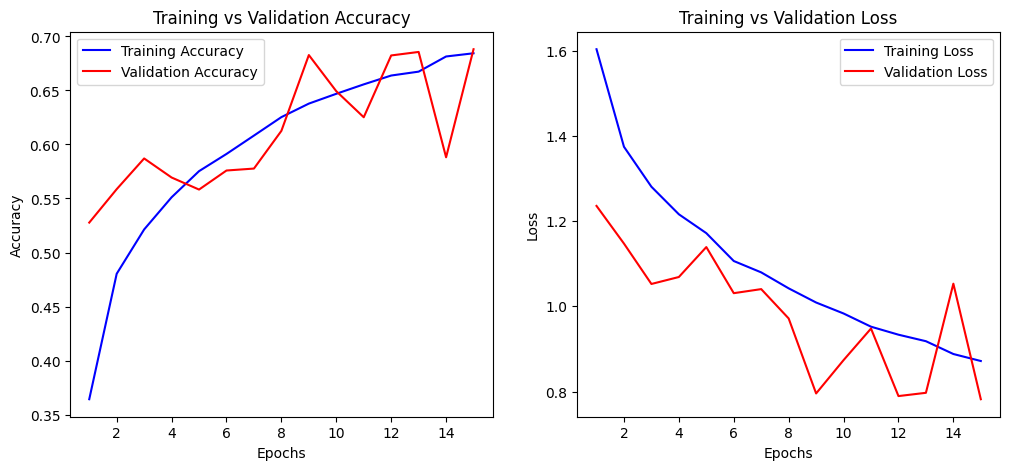

In [45]:
# extract metrics from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

# plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plot loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Look prediction for specific image

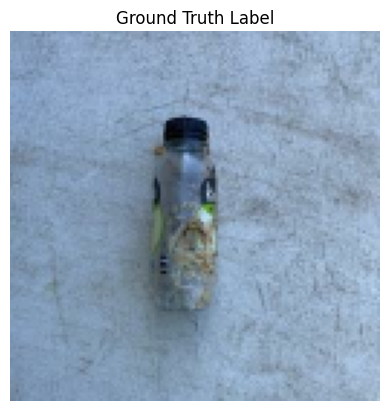

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
True class index: 4
Predicted class index: 4
Prediction probabilities: [0.05045807 0.01448604 0.28905264 0.02187205 0.62075037 0.00338091]


In [46]:
# take one from the test dataset
for images, labels in test_dataset.take(1):
    sample_image = images[0].numpy().astype("uint8")
    sample_label = labels[0].numpy()
    break

# plot image
plt.imshow(sample_image)
plt.axis("off")
plt.title("Ground Truth Label")
plt.show()

# prediction
img_array = np.expand_dims(sample_image, axis=0)  # model expects batch dimension
predictions = model.predict(img_array)

# convert prediction to class
predicted_class = np.argmax(predictions[0])
true_class = np.argmax(sample_label)

print("True class index:", true_class)
print("Predicted class index:", predicted_class)
print("Prediction probabilities:", predictions[0])

In [48]:
# convert class index to label
class_names = train_dataset.class_names
print("True label:", class_names[true_class])
print("Predicted label:", class_names[predicted_class])

True label: plastic
Predicted label: plastic


## PreTrained model

In [67]:
from tensorflow.keras.applications import MobileNetV2

pretrained_base = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,  # exclude final classifier
    weights="imagenet"  # use pretrained ImageNet weights
)

# freeze base model
pretrained_base.trainable = False

# add classification head
pretrained_model = models.Sequential([
    pretrained_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(6, activation="softmax")  # 6 class categories, softmax to sum up all the predictions to 1
])

In [68]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
pretrained_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [69]:
pretrained_history_1 = pretrained_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=5
)

Epoch 1/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 607s 2s/step - accuracy: 0.4455 - loss: 1.4593 - val_accuracy: 0.6924 - val_loss: 0.8740
Epoch 2/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 692s 2s/step - accuracy: 0.6001 - loss: 1.0714 - val_accuracy: 0.6669 - val_loss: 0.9002
Epoch 3/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 584s 2s/step - accuracy: 0.6400 - loss: 0.9663 - val_accuracy: 0.7201 - val_loss: 0.7798
Epoch 4/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 643s 2s/step - accuracy: 0.6723 - loss: 0.8906 - val_accuracy: 0.7683 - val_loss: 0.6814
Epoch 5/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 567s 2s/step - accuracy: 0.7026 - loss: 0.8236 - val_accuracy: 0.7162 - val_loss: 0.7584


In [70]:
# enable fine-tuning
pretrained_base.trainable = True
for layer in pretrained_base.layers[:-20]:  # freeze all but last 20 layers
    layer.trainable = False

# lower learning rate for fine-tuning
pretrained_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

pretrained_history_2 = pretrained_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=5
)

Epoch 1/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 733s 2s/step - accuracy: 0.5377 - loss: 1.3979 - val_accuracy: 0.8025 - val_loss: 0.6592
Epoch 2/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 740s 2s/step - accuracy: 0.7581 - loss: 0.6757 - val_accuracy: 0.7579 - val_loss: 0.7366
Epoch 3/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 718s 2s/step - accuracy: 0.8320 - loss: 0.4741 - val_accuracy: 0.6532 - val_loss: 1.0505
Epoch 4/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 691s 2s/step - accuracy: 0.8813 - loss: 0.3362 - val_accuracy: 0.7191 - val_loss: 0.8918
Epoch 5/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 687s 2s/step - accuracy: 0.9177 - loss: 0.2401 - val_accuracy: 0.6748 - val_loss: 1.1057


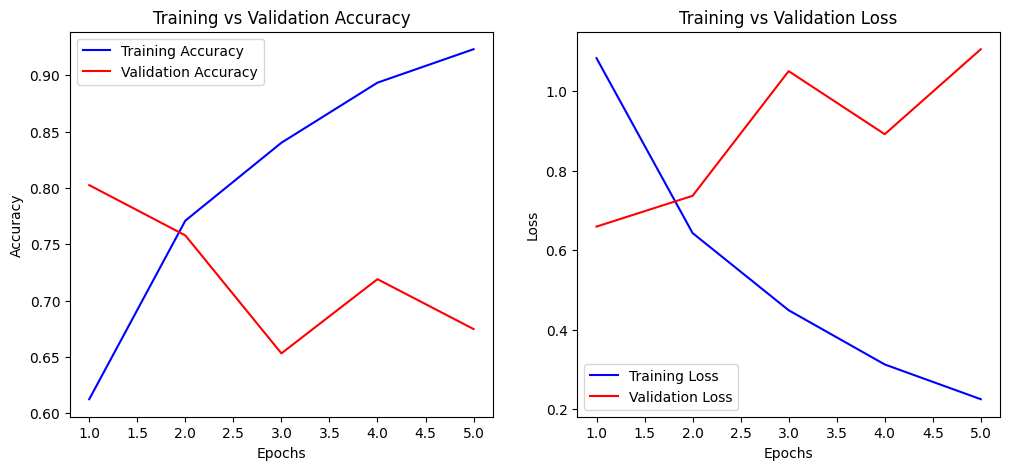

In [71]:
# extract metrics from history
acc = pretrained_history_2.history['accuracy']
val_acc = pretrained_history_2.history['val_accuracy']
loss = pretrained_history_2.history['loss']
val_loss = pretrained_history_2.history['val_loss']
epochs = range(1, len(acc)+1)

# plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plot loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()